### Mike Ogrysko
### CS 737 Machine Learning
Classification pipeline to predict if a passenger from Titanic survived or not - from Kaggle exercise https://www.kaggle.com/c/titanic/overview

In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVC, SVC

In [3]:
# Locate and load the data files
df_train_org = pd.read_csv('./assignment_titanic_train.csv')
df_test_org = pd.read_csv('./assignment_titanic_test.csv')

# Sanity check
print(f'train #rows={len(df_train_org)}, #columns={len(df_train_org.columns)}')
print(f'test #rows={len(df_test_org)}, #columns={len(df_test_org.columns)}')

train #rows=891, #columns=12
test #rows=418, #columns=11


**Data Exploration**

In [4]:
#look at test data columns and non-null values
df_test_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
#look at train data columns and non-null values
df_train_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


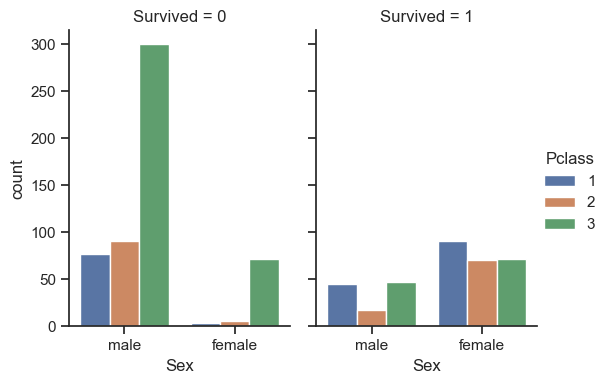

In [6]:
#look at the totals of survivors and non-survivors by sex and passenger class
sns.catplot(x="Sex", hue="Pclass", col="Survived", data=df_train_org, kind="count",height=4, aspect=.7);

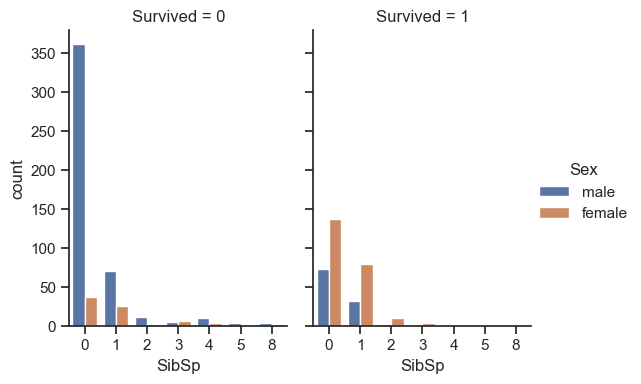

In [7]:
#look at the totals of survivors and non-survivors by sex and the number of siblings/spouses
sns.catplot(x="SibSp", hue="Sex", col="Survived", data=df_train_org, kind="count",height=4, aspect=.7);

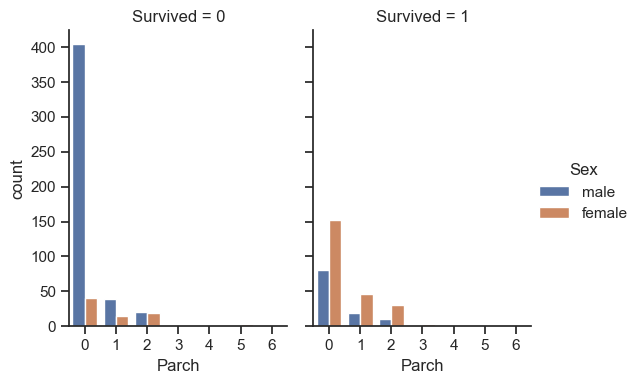

In [8]:
#look at the totals of survivors and non-survivors by sex and the number of parents/children
sns.catplot(x="Parch", hue="Sex", col="Survived", data=df_train_org, kind="count",height=4, aspect=.7);

In [9]:
#Number of null values in the train data set
df_train_org.isnull().sum() 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
#Number of null values in the test data set
df_test_org.isnull().sum() 

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [11]:
#we know that we can drop the cabin number and ticket number
df_train_org = df_train_org.drop(['Ticket','Cabin'], axis=1)
df_test_org = df_test_org.drop(['Ticket','Cabin'], axis=1)

In [12]:
#look at the empty Embarked records in trainin data set
df_train_org[df_train_org['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,NaN


In [13]:
#no sibling/spouse or parents/children, so use mode?
df_train_org['Embarked'].mode()

0    S
Name: Embarked, dtype: object

In [14]:
#filling Embarked with mode S
df_train_org['Embarked'].fillna('S', inplace=True)
df_train_org.isnull().sum() 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

In [15]:
#look at empty Fare value in test dataset
df_test_org[df_test_org['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,NaN,S


In [16]:
#use median fare value for passengers with the same Pclass and Embarked values?
df_test_org[(df_test_org['Pclass'] == 3) & (df_test_org['Embarked'] == 'S')].median()

PassengerId    1092.00
Pclass            3.00
Age              24.00
SibSp             0.00
Parch             0.00
Fare              8.05
dtype: float64

In [17]:
#filling Fare with median 8.05
df_test_org['Fare'].fillna(8.05, inplace=True)
df_test_org.isnull().sum() 

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            0
Embarked        0
dtype: int64

In [18]:
#use median age for missing age values
male_median_age = df_train_org[df_train_org['Sex'] == 'male']['Age'].median()
female_median_age = df_train_org[df_train_org['Sex'] == 'female']['Age'].median()
print("Train")
print('Male median age: ', male_median_age) 
print("Female median age: ", female_median_age)
te_male_median_age = df_test_org[df_test_org['Sex'] == 'male']['Age'].median()
te_female_median_age = df_test_org[df_test_org['Sex'] == 'female']['Age'].median()
print("Test")
print('Male median age: ', te_male_median_age) 
print("Female median age: ", te_female_median_age)

Train
Male median age:  29.0
Female median age:  27.0
Test
Male median age:  27.0
Female median age:  27.0


In [19]:
#fill in missing age values
df_train_org.loc[(df_train_org.Age.isnull()) & (df_train_org['Sex'] == 'male'),'Age'] = male_median_age
df_train_org.loc[(df_train_org.Age.isnull()) & (df_train_org['Sex'] == 'female'),'Age'] = female_median_age
df_test_org.loc[(df_test_org.Age.isnull()) & (df_test_org['Sex'] == 'male'),'Age'] = te_male_median_age
df_test_org.loc[(df_test_org.Age.isnull()) & (df_test_org['Sex'] == 'female'),'Age'] = te_female_median_age

In [20]:
#look at train dataset nulls
df_train_org.isnull().sum() 

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [21]:
#look at test dataset nulls
df_test_org.isnull().sum() 

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

**Feature Engineering**

In [23]:
#is the passenger traveling alone? 0 if no (sibling/spouse or parent/child > 0), 1 if yes
df_train_org['TravelAlone'] = 1
df_train_org.loc[((df_train_org['SibSp'] > 0) | (df_train_org['Parch'] > 0)), 'TravelAlone'] = 0
df_train_org.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,TravelAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [24]:
#add TravelAlone to the test set
df_test_org['TravelAlone'] = 1
df_test_org.loc[((df_test_org['SibSp'] > 0) | (df_test_org['Parch'] > 0)), 'TravelAlone'] = 0
df_test_org.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,TravelAlone
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,0


In [25]:
#a few resources online recommend stripping title from name
df_train_org['Title'] = [Name.split(',')[1].split('.')[0].strip() for Name in df_train_org['Name']]
df_train_org.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,TravelAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,Mr


In [26]:
#evaluate the number of titles
df_train_org['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

In [27]:
#combine titles where possible
df_train_org['Title'] = df_train_org['Title'].replace(['Mlle','Ms'],'Miss')
df_train_org['Title'] = df_train_org['Title'].replace(['Mme'],'Mrs')
df_train_org['Title'] = df_train_org['Title'].replace(['the Countess','Capt','Don','Jonkheer','Sir','Lady','Major','Col','Rev','Dr'],'Other')
df_train_org['Title'].value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Other      23
Name: Title, dtype: int64

In [28]:
#add title to test data set
df_test_org['Title'] = [Name.split(',')[1].split('.')[0].strip() for Name in df_test_org['Name']]
df_test_org['Title'] = df_test_org['Title'].replace(['Mlle','Ms'],'Miss')
df_test_org['Title'] = df_test_org['Title'].replace(['Mme'],'Mrs')
df_test_org['Title'] = df_test_org['Title'].replace(['the Countess','Capt','Don','Dona','Jonkheer','Sir','Lady','Major','Col','Rev','Dr'],'Other')
df_test_org['Title'].value_counts()


Mr        240
Miss       79
Mrs        72
Master     21
Other       6
Name: Title, dtype: int64

**Additional Cleanup**

In [29]:
#drop name since we have the passenger id and title
df_train_org = df_train_org.drop(['Name'], axis=1)
df_test_org = df_test_org.drop(['Name'], axis=1)

In [30]:
#drop SibSp and Parch with addition of TravelAlone
df_train_org = df_train_org.drop(['SibSp','Parch'], axis=1)
df_test_org = df_test_org.drop(['SibSp','Parch'], axis=1)

In [31]:
#check categorical features in train dataset
for col in df_train_org.columns:
    if df_train_org[col].dtype == object:
        print(col, df_train_org[col].unique())

Sex ['male' 'female']
Embarked ['S' 'C' 'Q']
Title ['Mr' 'Mrs' 'Miss' 'Master' 'Other']


In [32]:
#convert categorical features to numeric
#female = 0, male = 1
df_train_org.Sex = df_train_org.Sex.map({'female':0, 'male':1})
#S = 0, C = 1, Q = 2
df_train_org.Embarked=df_train_org.Embarked.map({'S':0, 'C':1, 'Q':2})
#Mr = 0, Mrs = 1, Miss = 2, Master = 3, Other = 4
df_train_org.Title=df_train_org.Title.map({'Mr':0, 'Mrs':1, 'Miss':2,'Master':3,'Other':4})

In [33]:
#check categorical features in test dataset
for col in df_test_org.columns:
    if df_test_org[col].dtype == object:
        print(col, df_test_org[col].unique())
#convert categorical features to numeric in test dataset
#female = 0, male = 1
df_test_org.Sex = df_test_org.Sex.map({'female':0, 'male':1})
#S = 0, C = 1, Q = 2
df_test_org.Embarked=df_test_org.Embarked.map({'S':0, 'C':1, 'Q':2})
#Mr = 0, Mrs = 1, Miss = 2, Master = 3, Other = 4
df_test_org.Title=df_test_org.Title.map({'Mr':0, 'Mrs':1, 'Miss':2,'Master':3,'Other':4})

Sex ['male' 'female']
Embarked ['Q' 'S' 'C']
Title ['Mr' 'Mrs' 'Miss' 'Master' 'Other']


In [35]:
#replace age with ordinals
df_train_org['AgeCats'] = pd.cut(df_train_org['Age'],5)
df_train_org[['AgeCats','Survived']].groupby('AgeCats', as_index = False).mean().sort_values(by = 'AgeCats')

,AgeCats,Survived
0,"(0.34, 16.336]",0.550000
1,"(16.336, 32.252]",0.344168
2,"(32.252, 48.168]",0.404255
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


In [36]:
#replace ages
df_train_org.loc[(df_train_org['Age'] <= 16.336), 'Age'] = 0
df_train_org.loc[((df_train_org['Age'] > 16.336) & (df_train_org['Age'] <= 32.252)), 'Age'] = 1
df_train_org.loc[((df_train_org['Age'] > 32.252) & (df_train_org['Age'] <= 48.168)), 'Age'] = 2
df_train_org.loc[((df_train_org['Age'] > 48.168) & (df_train_org['Age'] <= 64.084)), 'Age'] = 3
df_train_org.loc[(df_train_org['Age'] > 64.084), 'Age'] = 4
#drop AgeCats
df_train_org = df_train_org.drop(['AgeCats'], axis=1)


In [37]:
#convert age to int
df_train_org['Age'] = df_train_org['Age'].apply(np.int64)
df_train_org.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,TravelAlone,Title
0,1,0,3,1,1,7.2500,0,0,0
1,2,1,1,0,2,71.2833,1,0,1
2,3,1,3,0,1,7.9250,0,1,2
3,4,1,1,0,2,53.1000,0,0,1
4,5,0,3,1,2,8.0500,0,1,0


In [38]:
#convert age in test dataset
df_test_org['AgeCats'] = pd.cut(df_test_org['Age'],5)
df_test_org.loc[(df_test_org['Age'] <= 16.336), 'Age'] = 0
df_test_org.loc[((df_test_org['Age'] > 16.336) & (df_test_org['Age'] <= 32.252)), 'Age'] = 1
df_test_org.loc[((df_test_org['Age'] > 32.252) & (df_test_org['Age'] <= 48.168)), 'Age'] = 2
df_test_org.loc[((df_test_org['Age'] > 48.168) & (df_test_org['Age'] <= 64.084)), 'Age'] = 3
df_test_org.loc[(df_test_org['Age'] > 64.084), 'Age'] = 4
df_test_org = df_test_org.drop(['AgeCats'], axis=1)
df_test_org['Age'] = df_test_org['Age'].apply(np.int64)
df_test_org.head()


,PassengerId,Pclass,Sex,Age,Fare,Embarked,TravelAlone,Title
0,892,3,1,2,7.8292,2,1,0
1,893,3,0,2,7.0000,0,0,1
2,894,2,1,3,9.6875,2,1,0
3,895,3,1,1,8.6625,0,1,0
4,896,3,0,1,12.2875,0,0,1


In [39]:
#replace fare with ordinals
df_train_org['FareCats'] = pd.cut(df_train_org['Fare'],5)
df_train_org[['FareCats','Survived']].groupby('FareCats', as_index = False).mean().sort_values(by = 'FareCats')


,FareCats,Survived
0,"(-0.512, 102.466]",0.361575
1,"(102.466, 204.932]",0.757576
2,"(204.932, 307.398]",0.647059
3,"(307.398, 409.863]",NaN
4,"(409.863, 512.329]",1.000000


In [40]:
#replace fares
df_train_org.loc[(df_train_org['Fare'] <= 102.466), 'Fare'] = 0
df_train_org.loc[((df_train_org['Fare'] > 102.466) & (df_train_org['Fare'] <= 204.932)), 'Age'] = 1
df_train_org.loc[((df_train_org['Fare'] > 204.932) & (df_train_org['Fare'] <= 307.398)), 'Age'] = 2
df_train_org.loc[((df_train_org['Fare'] > 307.398) & (df_train_org['Fare'] <= 409.863)), 'Age'] = 3
df_train_org.loc[(df_train_org['Fare'] > 409.863), 'Fare'] = 4
#drop AgeCats
df_train_org = df_train_org.drop(['FareCats'], axis=1)

In [41]:
#convert fare to int
df_train_org['Fare'] = df_train_org['Fare'].apply(np.int64)
df_train_org.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,TravelAlone,Title
0,1,0,3,1,1,0,0,0,0
1,2,1,1,0,2,0,1,0,1
2,3,1,3,0,1,0,0,1,2
3,4,1,1,0,2,0,0,0,1
4,5,0,3,1,2,0,0,1,0


In [42]:
#convert fare in test dataset
df_test_org['FareCats'] = pd.cut(df_test_org['Fare'],5)
df_test_org.loc[(df_test_org['Fare'] <= 102.466), 'Fare'] = 0
df_test_org.loc[((df_test_org['Fare'] > 102.466) & (df_test_org['Fare'] <= 204.932)), 'Age'] = 1
df_test_org.loc[((df_test_org['Fare'] > 204.932) & (df_test_org['Fare'] <= 307.398)), 'Age'] = 2
df_test_org.loc[((df_test_org['Fare'] > 307.398) & (df_test_org['Fare'] <= 409.863)), 'Age'] = 3
df_test_org.loc[(df_test_org['Fare'] > 409.863), 'Fare'] = 4
df_test_org = df_test_org.drop(['FareCats'], axis=1)
df_test_org['Fare'] = df_test_org['Fare'].apply(np.int64)
df_test_org.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,TravelAlone,Title
0,892,3,1,2,0,2,1,0
1,893,3,0,2,0,0,0,1
2,894,2,1,3,0,2,1,0
3,895,3,1,1,0,0,1,0
4,896,3,0,1,0,0,0,1


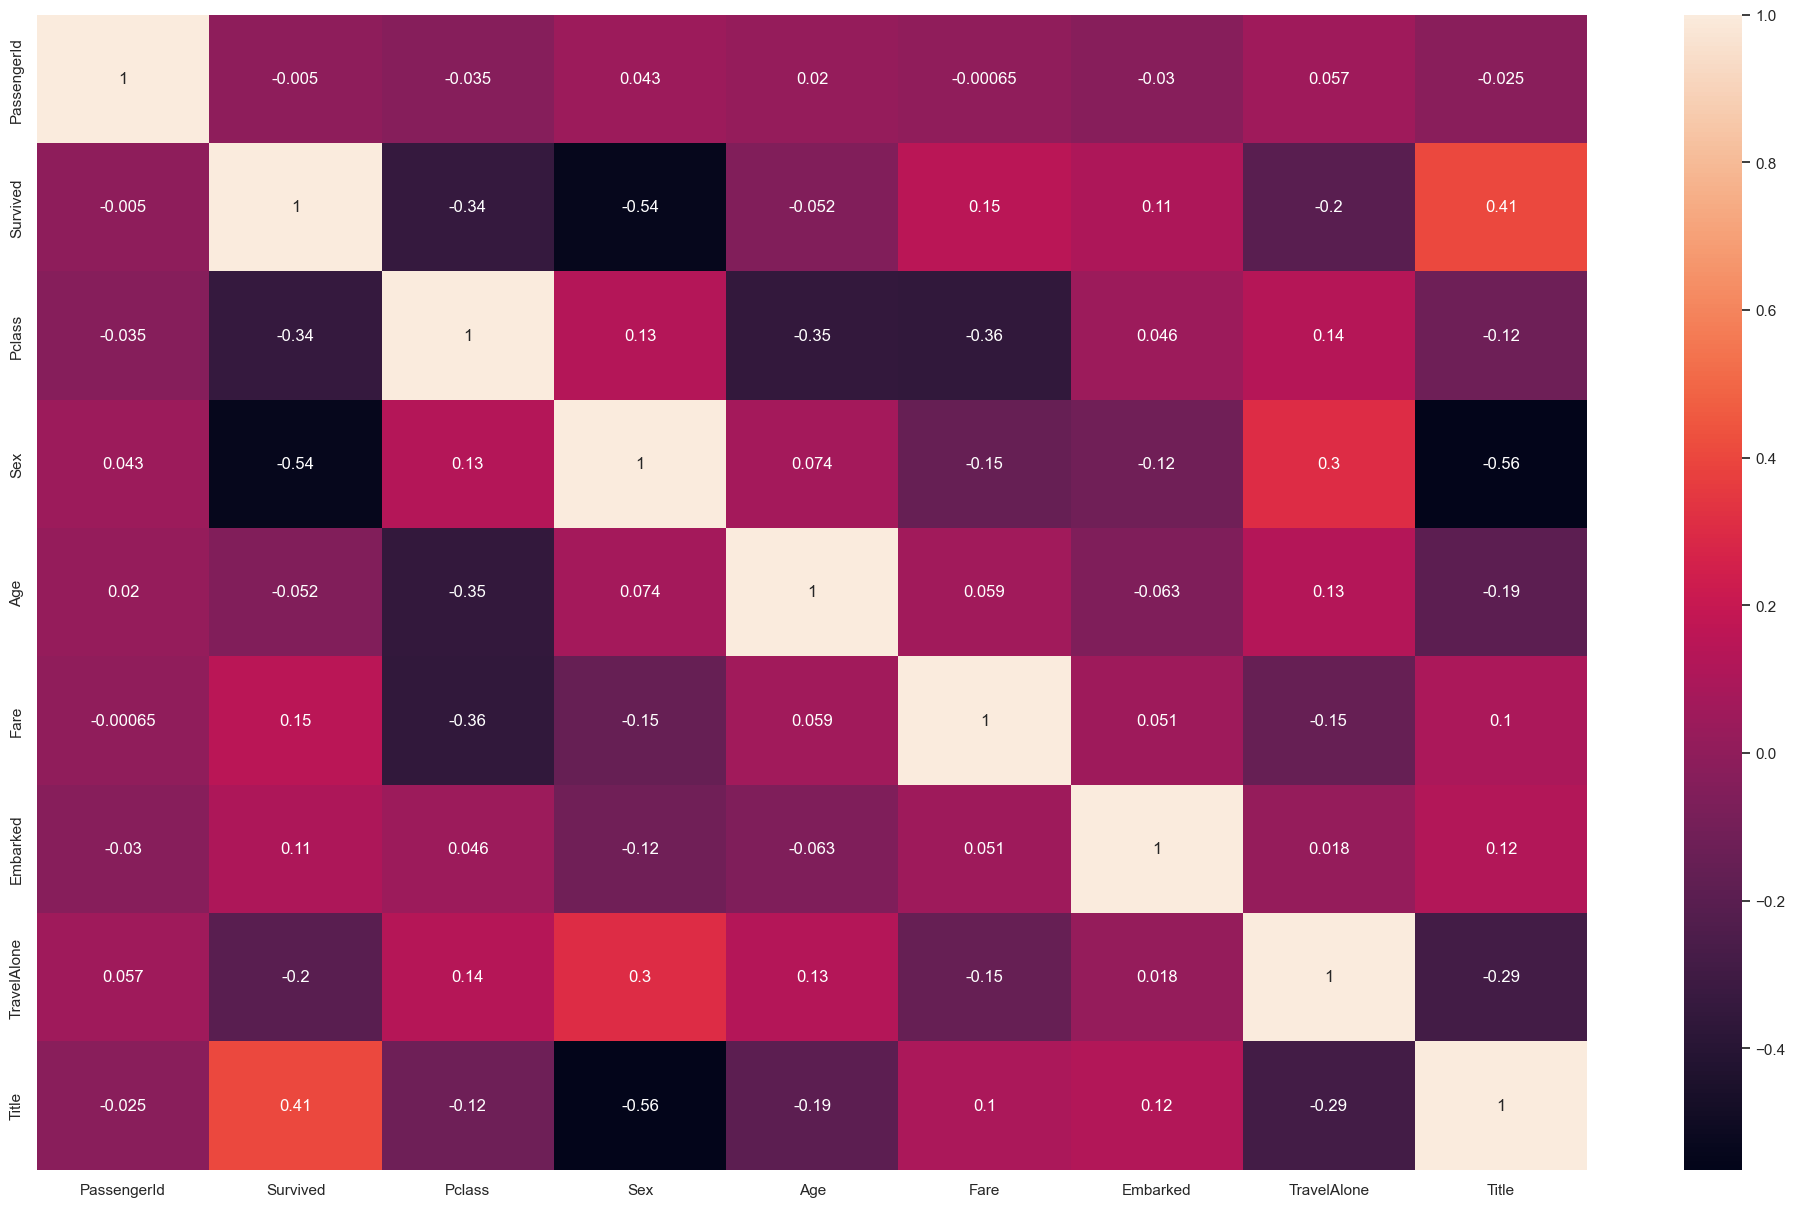

In [46]:
#correlation
X = df_train_org.values
N, M = X.shape
#Average of features
Xavg = np.zeros(M) 
for i in range(M):
    Xavg[i] = df_train_org.iloc[:,i].mean()

Xcor = np.zeros((M,M))
for x in range(M):
    for y in range(M):
        Xcor[x,y] = np.sum((X[:,x] - Xavg[x]) * (X[:,y] - Xavg[y])) / ((np.sqrt(np.sum((X[:,x] - Xavg[x])**2))) * (np.sqrt(np.sum((X[:,y] - Xavg[y])**2))))

cols = df_train_org.columns
sns.heatmap(Xcor, annot=True, xticklabels=cols, yticklabels=cols)
sns.set(rc = {'figure.figsize':(30,15)})
plt.show()

**Model**

In [47]:
X_train = df_train_org.drop(['Survived'], axis=1)
y_train = df_train_org['Survived']
X_test = df_test_org


In [48]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (891, 8)
y_train shape:  (891,)
X_test shape:  (418, 8)


In [49]:
#svm
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
acc_svc

63.86

In [50]:
#random forest
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = round(rf.score(X_train, y_train) * 100, 2)
acc_rf


100.0

In [51]:
#logistic regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
acc_lr = round(lr.score(X_train, y_train) * 100, 2)
acc_lr


78.23

In [52]:
def save_preds(_fn, _y_pred, _df):
    import csv
    with open(_fn, 'w') as fout:
        writer = csv.writer(fout, delimiter=',', lineterminator='\n')
        writer.writerow(['Survived', 'PassengerId'])
        for y, passengerId in zip(_y_pred, _df['PassengerId']):
            writer.writerow([y, passengerId])

In [53]:
save_preds('predictions_ogrysko.csv', y_pred, df_test_org)

In [54]:
save_preds('predictions_ogrysko_rf.csv', y_pred_rf, df_test_org)

In [55]:
save_preds('predictions_ogrysko_lr.csv', y_pred_lr, df_test_org)

**Final Accuracies - From Kaggle**

SVM - Score: 0.63157<br>
RF - Score: 0.75598<br>
LR - Score: 0.76794